In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import xarray as xr
import pandas as pd
import seaborn as sns
import scipy

import itertools
import datetime
import time
import sys  
import re

sys.path.insert(0, '../')

from soundings.deep_learning import mlutilities as ml
from soundings.deep_learning import tf_neuralnetwork as nn
from soundings.deep_learning import tf_metrics as metrics

from soundings.preprocessing import dataloader as dl

from soundings.plotting import radiosonde_plotting, results
from soundings.utils import radiosonde_products, radiosonde_utils

from IPython.display import display
from ipywidgets import FloatProgress

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

In [2]:
processed_vol = '/mnt/data1/stock/mlsoundings/processed/'
PLOT_CMAP = 'RdYlBu_r'

gpus = tf.config.get_visible_devices('GPU')
for device in gpus:
    print(device)
    # tf.config.experimental.set_visible_devices(device, 'GPU')
    tf.config.experimental.set_memory_growth(device, True)
print()
!nvidia-smi

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')

Fri Mar  5 17:43:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 6000     Off  | 00000000:3D:00.0 Off |                  Off |
| 33%   32C    P8    12W / 260W |     16MiB / 24212MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----

# Evaluation Functions

In [3]:
def parition(rap=None, raob=None, goes=None, rtma=None, 
             percentages=(0.8,0.2), shuffle=False):
    
    trainFraction, testFraction = percentages
    n = raob.shape[0]
    nTrain = round(trainFraction * n)
    nTest = round(testFraction * n)
    rowIndices = np.arange(n)
    if shuffle:
        np.random.shuffle(rowIndices)
        
    RAPtrain  = None
    RAPtest   = None
    RAOBtrain = None
    RAOBtest  = None
    GOEStrain = None
    GOEStest  = None
    RTMAtrain = None
    RTMAtest  = None
    
    if rap is not None:
        RAPtrain = rap[rowIndices[:nTrain], :]
        RAPtest  = rap[rowIndices[nTrain:nTrain+nTest], :]
        
    if raob is not None:
        RAOBtrain = raob[rowIndices[:nTrain], :]
        RAOBtest  = raob[rowIndices[nTrain:nTrain+nTest], :]
        
    if goes is not None:
        GOEStrain = goes[rowIndices[:nTrain], :]
        GOEStest  = goes[rowIndices[nTrain:nTrain+nTest], :]
        
    if rtma is not None:
        RTMAtrain = rtma[rowIndices[:nTrain], :]
        RTMAtest  = rtma[rowIndices[nTrain:nTrain+nTest], :]
    
    return (RAPtrain, RAOBtrain, GOEStrain, RTMAtrain,
            RAPtest, RAOBtest, GOEStest, RTMAtest)

# Data Loader

In [4]:
raob, rap, goes, rtma, sonde_files = dl.load_preprocessed_samples(processed_vol, shuffle=True)

print(raob.shape, rap.shape, goes.shape, rtma.shape)

total of 1283 samples!


FloatProgress(value=0.0, max=1283.0)

time: 33.411, avg: 0.026 seconds
(1283, 256, 4) (1283, 256, 4) (1283, 3, 3, 8) (1283, 3, 3, 3)


In [4]:
# f = '/mnt/data1/stock/mlsoundings/preprocessed.npz'
f = '/mnt/data1/stock/mlsoundings/preprocessed_alley.npz'

# np.savez(f, raob=raob, rap=rap,
#          goes=goes, rtma=rtma, sonde_files=sonde_files)

container = np.load(f)

print(container.files)

raob = container['raob']
rap = container['rap']
goes = container['goes']
rtma = container['rtma']
sonde_files = container['sonde_files']

# diff = raob[:,:,dl.TEMPERATURE] - rap[:,:,dl.TEMPERATURE]
# threshold = 20
# inds = np.unique(np.where(abs(diff) >= threshold)[0])

# raob = np.delete(raob, inds, 0)
# rap  = np.delete(rap, inds, 0)
# goes = np.delete(goes, inds, 0)
# rtma = np.delete(rtma, inds, 0)
# sonde_files = np.delete(sonde_files, inds, 0)

print(raob.shape, rap.shape, goes.shape, rtma.shape)

['raob', 'rap', 'goes', 'rtma', 'sonde_files']
(38373, 256, 4) (38373, 256, 4) (38373, 3, 3, 8) (38373, 3, 3, 3)


In [5]:
ml.rmse(rap[:,:,dl.DEWPOINT], raob[:,:,dl.DEWPOINT]), ml.rmse(rap[:,:,dl.TEMPERATURE], raob[:,:,dl.TEMPERATURE])

(6.229964948876949, 1.064032419889006)

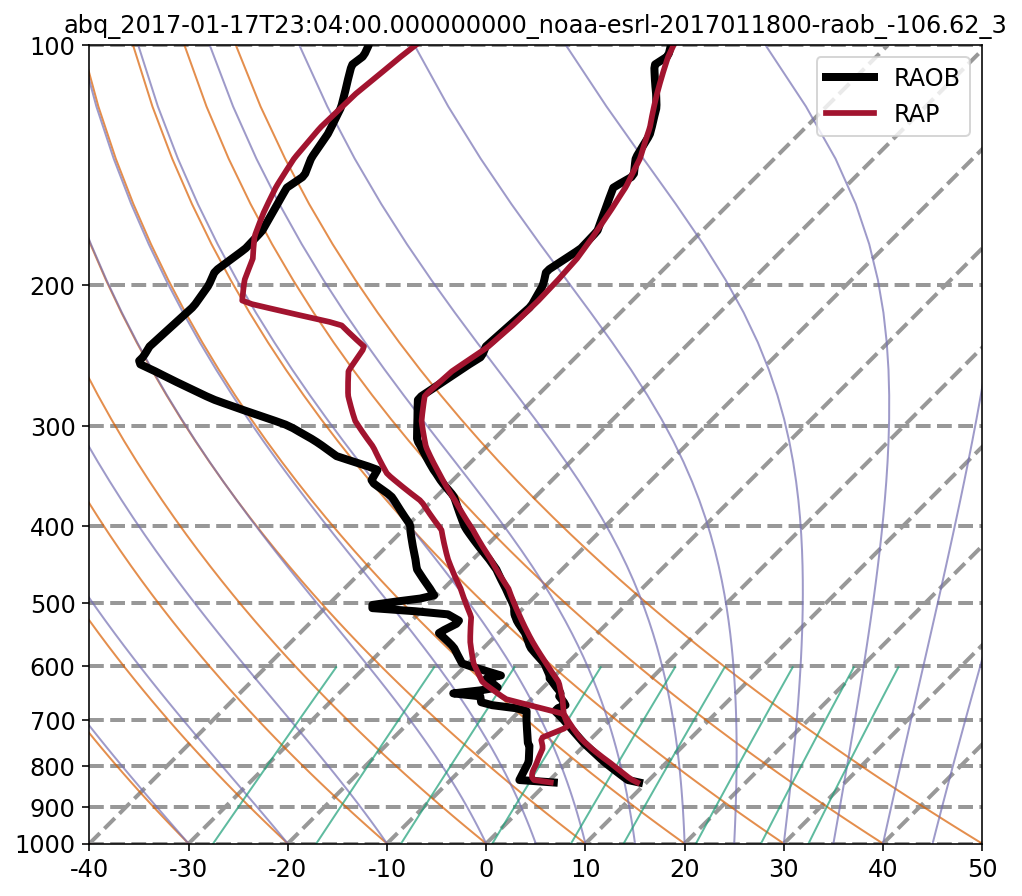

In [4]:
index = 5
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = rap[index,:,dl.PRESSURE]

sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = raob[index,:,dl.TEMPERATURE]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = rap[index,:,dl.TEMPERATURE]

sounding[radiosonde_utils.DEWPOINT_COLUMN_KEY] = raob[index,:,dl.DEWPOINT]
sounding[radiosonde_utils.NWP_DEWPOINT_COLUMN_KEY] = rap[index,:,dl.DEWPOINT]

title = sonde_files[index].split('/')[-1][:-4]
radiosonde_plotting.plot_nwp_ml_sounding(sounding, title_string=title);
                                         # file_name=f"/home/stock/research/media/{title}-rapvraob.png");

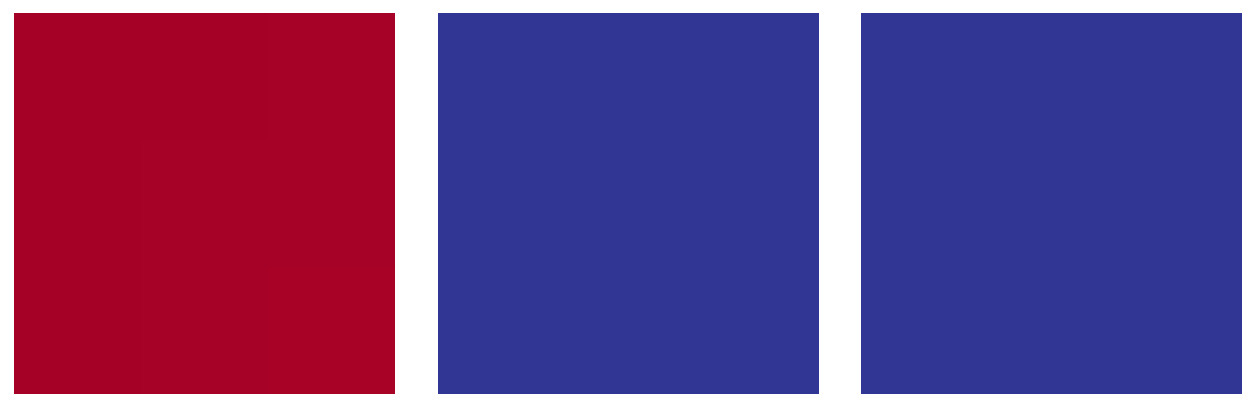

In [6]:
rtma_type = np.array(['LPI', 'LRI', 'LTI'])

vmin = rtma[index,:,:,:].min()
vmax = rtma[index,:,:,:].max()

fig, axs = plt.subplots(1, 3, figsize=(9,3))
[axi.set_axis_off() for axi in axs.ravel()]
for i in range(3):
    c = axs[i].imshow(rtma[index,:,:,i], vmin=vmin, vmax=vmax, cmap=PLOT_CMAP)
#     fig.colorbar(c, ax=axs[i], fraction=0.046, pad=0.04)
#     axs[i].set_title(f'{str(rtma_type[i])}')
# fig.suptitle('RTMA', fontsize=20)
fig.tight_layout()
fig.savefig('/home/stock/research/media/dims/rtma_dims', dpi=300)

In [6]:
p_raob_diff = np.cbrt(np.abs(rtma[:, 1, 1, 0] / 100. - raob[:, 0, dl.PRESSURE]))
r_raob_diff = np.cbrt(np.abs(rtma[:, 1, 1, 1] - 273.15 - raob[:, 0, dl.DEWPOINT]))
t_raob_diff = np.cbrt(np.abs(rtma[:, 1, 1, 2] - 273.15 - raob[:, 0, dl.TEMPERATURE]))

p_rap_diff = np.cbrt(np.abs(rtma[:, 1, 1, 0] / 100. - rap[:, 0, dl.PRESSURE]))
r_rap_diff = np.cbrt(np.abs(rtma[:, 1, 1, 1] - 273.15 - rap[:, 0, dl.DEWPOINT]))
t_rap_diff = np.cbrt(np.abs(rtma[:, 1, 1, 2] - 273.15 - rap[:, 0, dl.TEMPERATURE]))

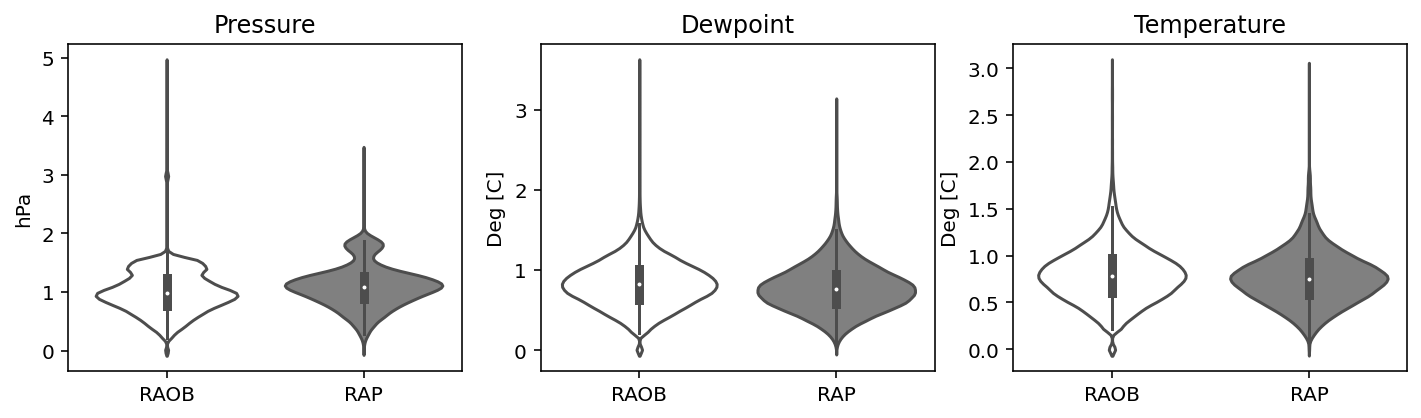

In [7]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))
axs = axs.ravel()
palette = ['white', 'gray']

sns.violinplot(data=[p_raob_diff, p_rap_diff], palette=palette, ax=axs[0])
axs[0].set_title('Pressure'); # axs[0].set_ylim(-0.5, 5); 
axs[0].set_xticklabels(['RAOB', 'RAP'])
axs[0].set_ylabel('hPa')

sns.violinplot(data=[r_raob_diff, r_rap_diff], palette=palette, ax=axs[1])
axs[1].set_title('Dewpoint'); # axs[1].set_ylim(-0.5, 5);
axs[1].set_xticklabels(['RAOB', 'RAP'])
axs[1].set_ylabel('Deg [C]')

sns.violinplot(data=[t_raob_diff, t_rap_diff], palette=palette, ax=axs[2])
axs[2].set_title('Temperature'); # axs[2].set_ylim(-0.5, 5); 
axs[2].set_xticklabels(['RAOB', 'RAP'])
axs[2].set_ylabel('Deg [C]');

# plt.savefig('/home/stock/research/media/rtma-vs-rap-raob.pdf', dpi=300)

In [8]:
p_raob_diff = rtma[:, 1, 1, 0] / 100. - raob[:, 0, dl.PRESSURE]
r_raob_diff = rtma[:, 1, 1, 1] - 273.15 - raob[:, 0, dl.DEWPOINT]
t_raob_diff = rtma[:, 1, 1, 2] - 273.15 - raob[:, 0, dl.TEMPERATURE]

p_rap_diff = rtma[:, 1, 1, 0] / 100. - rap[:, 0, dl.PRESSURE]
r_rap_diff = rtma[:, 1, 1, 1] - 273.15 - rap[:, 0, dl.DEWPOINT]
t_rap_diff = rtma[:, 1, 1, 2] - 273.15 - rap[:, 0, dl.TEMPERATURE]

In [9]:
compare_data = []
for raob_diff, rap_diff in zip(p_raob_diff, p_rap_diff):
    compare_data.append({'type': 'Pressure', 'RAOB': raob_diff, 'RAP': rap_diff})
for raob_diff, rap_diff in zip(r_raob_diff, r_rap_diff):
    compare_data.append({'type': 'Dewpoint', 'RAOB': raob_diff, 'RAP': rap_diff})
for raob_diff, rap_diff in zip(t_raob_diff, t_rap_diff):
    compare_data.append({'type': 'Temperature', 'RAOB': raob_diff, 'RAP': rap_diff})
df = pd.DataFrame(compare_data)

In [10]:
print(np.mean(p_raob_diff), np.std(p_raob_diff))
print(np.mean(r_raob_diff), np.std(r_raob_diff))
print(np.mean(t_raob_diff), np.std(t_raob_diff))

-0.10659325670525581 2.6774337931287837
0.0958472967576537 1.3702617352499928
0.06811034494570564 1.2161846206302693


In [11]:
print(np.mean(p_rap_diff), np.std(p_rap_diff))
print(np.mean(r_rap_diff), np.std(r_rap_diff))
print(np.mean(t_rap_diff), np.std(t_rap_diff))

-0.9390280373936227 2.313544636911419
0.06836463027443927 1.1821683339967528
-0.05447253889099494 1.144509170641086


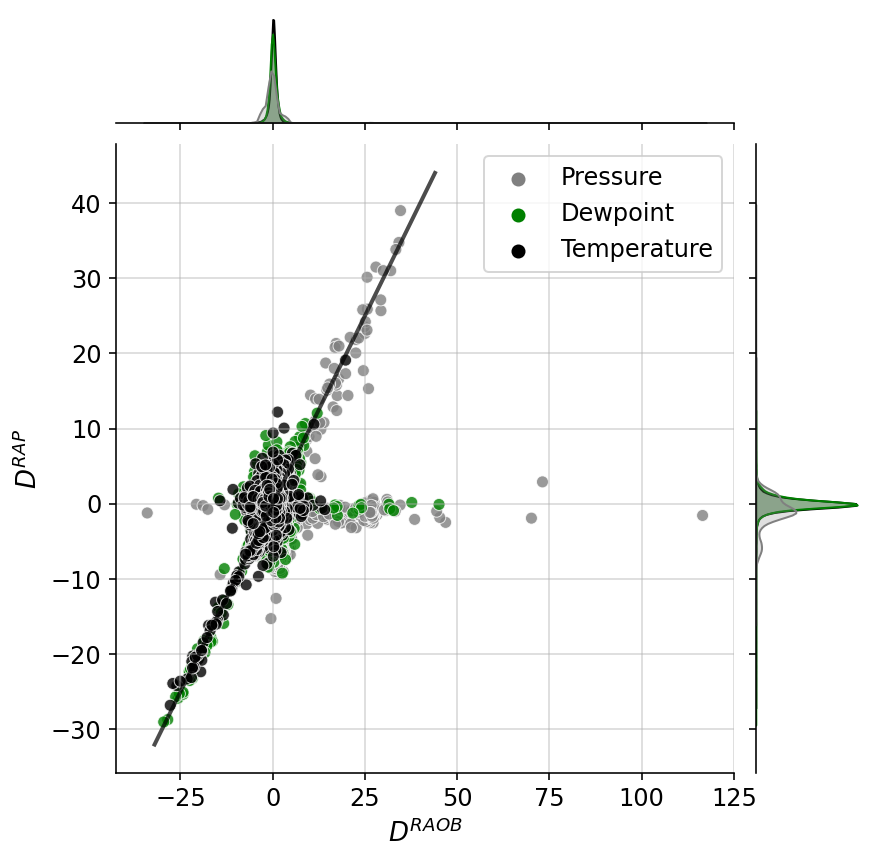

In [26]:
default_font = 12
x = np.arange(-32, 45)
# { “scatter” | “kde” | “hist” | “hex” | “reg” | “resid” }
g = sns.jointplot(data=df, x="RAOB", y="RAP", hue="type", palette=['gray', 'green', 'black'],
                  alpha=0.8, kind='scatter')
g.ax_joint.plot(x, x, 'k-', linewidth = 2, alpha=0.7)
g.ax_joint.set_xlabel('$D^{RAOB}$',fontsize=default_font+1)
g.ax_joint.set_ylabel('$D^{RAP}$',fontsize=default_font+1)
g.ax_joint.legend(fontsize=12)
g.ax_joint.tick_params(axis='x', labelsize=default_font)
g.ax_joint.tick_params(axis='y', labelsize=default_font)
g.ax_joint.grid(True, alpha=0.5);
# plt.savefig('/home/stock/research/media/rtma_vs_rap_raob_jointplot.png', dpi=300, bbox_inches='tight')

In [27]:
def summarise(d):
    print(f'n   : {len(d)}')
    print(f'mean: {np.mean(d):.3f}')
    print(f'sd  : {np.std(d):.3f}')
    print(f'se  : {np.std(d)/np.sqrt(len(d)):.3f}')
    print('--------------')

In [28]:
print('Pressure')
summarise(p_raob_diff)
print('Dewpoint')
summarise(r_raob_diff)
print('Temperature')
summarise(t_raob_diff)

Pressure
n   : 38373
mean: -0.107
sd  : 2.677
se  : 0.014
--------------
Dewpoint
n   : 38373
mean: 0.096
sd  : 1.370
se  : 0.007
--------------
Temperature
n   : 38373
mean: 0.068
sd  : 1.216
se  : 0.006
--------------


In [29]:
print('Pressure')
summarise(p_rap_diff)
print('Dewpoint')
summarise(r_rap_diff)
print('Temperature')
summarise(t_rap_diff)

Pressure
n   : 38373
mean: -0.939
sd  : 2.314
se  : 0.012
--------------
Dewpoint
n   : 38373
mean: 0.068
sd  : 1.182
se  : 0.006
--------------
Temperature
n   : 38373
mean: -0.054
sd  : 1.145
se  : 0.006
--------------


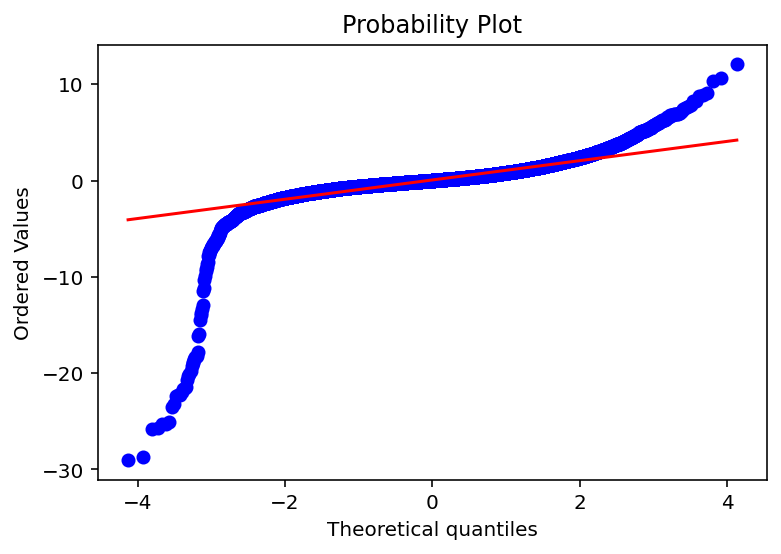

In [22]:
scipy.stats.probplot(r_rap_diff, plot=plt);

In [47]:
# p_diff = p_raob_diff - p_rap_diff
# r_diff = r_raob_diff - r_rap_diff
# t_diff = t_raob_diff - t_rap_diff

p_diff = np.abs(p_raob_diff) - np.abs(p_rap_diff)
r_diff = np.abs(r_raob_diff) - np.abs(r_rap_diff)
t_diff = np.abs(t_raob_diff) - np.abs(t_rap_diff)

p_diff = np.cbrt(p_diff)
r_diff = np.cbrt(r_diff)
t_diff = np.cbrt(t_diff)

compare_data = [{'type': 'Pressure', 'model': 'RAOB', 'data': p_diff},
                {'type': 'Dewpoint', 'model': 'RAOB', 'data': r_diff},
                {'type': 'Temperature', 'model': 'RAOB', 'data': t_diff}]

df = pd.DataFrame(compare_data)
lst_col = 'data'
df = pd.DataFrame({col:np.repeat(df[col].values, df[lst_col].str.len())
                   for col in df.columns.difference([lst_col])
                  }).assign(**{lst_col:np.concatenate(df[lst_col].values)})[df.columns.tolist()]

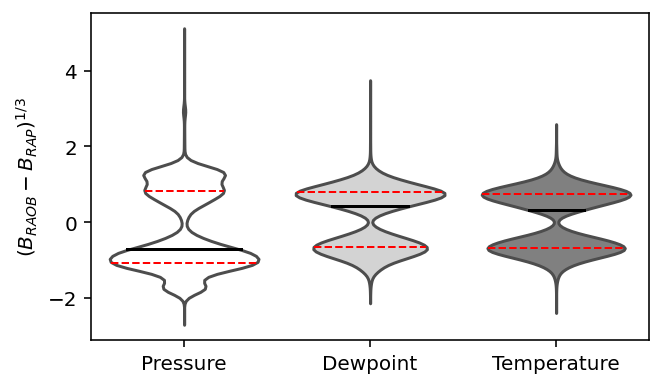

In [48]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 3))

palette = ['white', 'lightgray', 'gray']

sns.violinplot(x='type', y='data', data=df, scale='count',
               palette=palette, inner='quartile', ax=ax)

for l in ax.lines:
    l.set_linestyle('--')
    l.set_linewidth(1)
    l.set_color('red')
    
for l in ax.lines[1::3]:
    l.set_linestyle('-')
    l.set_linewidth(1.5)
    l.set_color('black')
    
ax.set_ylabel('$(B_{RAOB} - B_{RAP})^{1/3}$'); ax.set_xlabel(None); # (RTMA - RAOB) - (RTMA - RAP) $\sqrt[3]{|RTMA - X|}$

# plt.savefig('/home/stock/research/media/rtma_vs_rap_raob_2.pdf', dpi=300, bbox_inches='tight')

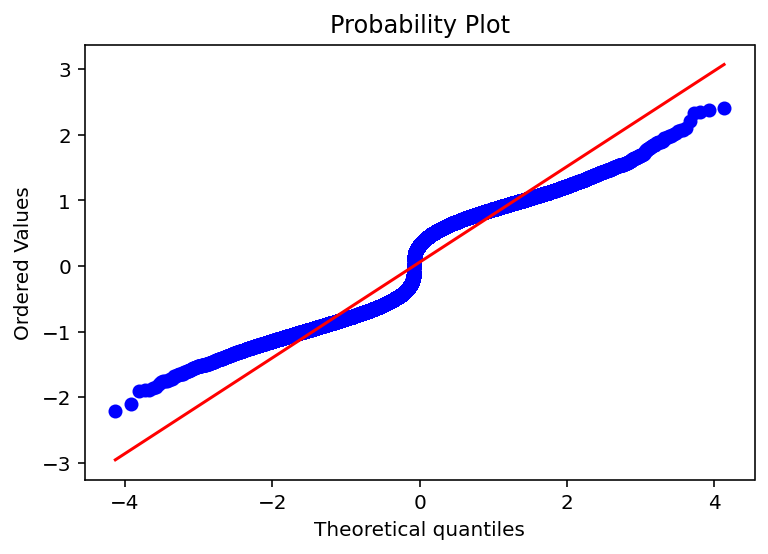

In [25]:
scipy.stats.probplot(t_diff, plot=plt);

In [40]:
print(np.mean(p_raob_diff), np.std(p_raob_diff))
print(np.mean(r_raob_diff), np.std(r_raob_diff))
print(np.mean(t_raob_diff), np.std(t_raob_diff))

-0.10659325670525581 2.6774337931287837
0.0958472967576537 1.3702617352499928
0.06811034494570564 1.2161846206302693


In [35]:
print(np.corrcoef(rtma[:, 1, 1, 0] / 100., raob[:, 0, dl.PRESSURE])[1,0])
print(np.corrcoef(rtma[:, 1, 1, 0] / 100., rap[:, 0, dl.PRESSURE])[1,0])
print(np.corrcoef(rtma[:, 1, 1, 1] - 273.15, raob[:, 0, dl.DEWPOINT])[1,0])
print(np.corrcoef(rtma[:, 1, 1, 1] - 273.15, rap[:, 0, dl.DEWPOINT])[1,0])
# r_diff = r_raob_diff - r_rap_diff
# t_diff = t_raob_diff - t_rap_diff)

0.9973102855252932
0.9979692691750922
0.9920322575361391
0.9941089082908968


In [50]:
print(np.corrcoef(p_raob_diff, p_rap_diff)[1,0])
print(np.corrcoef(r_raob_diff, r_rap_diff)[1,0])
print(np.corrcoef(t_raob_diff, t_rap_diff)[1,0])

-0.07076706814402364
0.45556316590132756
0.5324765725584968


In [49]:
print(scipy.stats.wilcoxon(p_diff))
print(scipy.stats.wilcoxon(r_diff))
print(scipy.stats.wilcoxon(t_diff))

WilcoxonResult(statistic=280434432.0, pvalue=0.0)
WilcoxonResult(statistic=303538022.5, pvalue=1.0530316585595853e-194)
WilcoxonResult(statistic=334037900.5, pvalue=2.4161942425227216e-55)


In [57]:
def summarise(d):
    print(f'n   : {len(d)}')
    print(f'mean: {np.mean(d):.3f}')
    print(f'sd  : {np.std(d):.3f}')
    print(f'se  : {np.std(d)/np.sqrt(len(d)):.3f}')
    print('--------------')
    
print('Pressure')
summarise(p_diff)
print('Dewpoint')
summarise(r_diff)
print('Temperature')
summarise(t_diff)

Pressure
n   : 38373
mean: -0.237
sd  : 1.059
se  : 0.005
--------------
Dewpoint
n   : 38373
mean: 0.119
sd  : 0.783
se  : 0.004
--------------
Temperature
n   : 38373
mean: 0.059
sd  : 0.766
se  : 0.004
--------------


In [98]:
print(scipy.stats.wilcoxon(p_diff))
print(scipy.stats.wilcoxon(r_diff))
print(scipy.stats.wilcoxon(t_diff))

WilcoxonResult(statistic=285681199.5, pvalue=0.0)
WilcoxonResult(statistic=365731997.0, pvalue=0.26885092494387886)
WilcoxonResult(statistic=288109019.0, pvalue=4.23941123139807e-297)


In [65]:
print(scipy.stats.ttest_1samp(p_diff, 0.0, alternative='greater'))
print(scipy.stats.ttest_1samp(r_diff, 0.0, alternative='greater'))
print(scipy.stats.ttest_1samp(t_diff, 0.0, alternative='greater'))

Ttest_1sampResult(statistic=44.54918986947115, pvalue=0.0)
Ttest_1sampResult(statistic=4.013502028631685, pvalue=2.9968999290958688e-05)
Ttest_1sampResult(statistic=21.00658895917867, pvalue=1.011132253238555e-97)


In [ ]:
# p_raob_diff = np.cbrt(np.abs(p_raob_diff))
# r_raob_diff = np.cbrt(np.abs(r_raob_diff))
# t_raob_diff = np.cbrt(np.abs(t_raob_diff))
# p_rap_diff = np.cbrt(np.abs(p_rap_diff))
# r_rap_diff = np.cbrt(np.abs(r_rap_diff))
# t_rap_diff = np.cbrt(np.abs(t_rap_diff))

compare_data = [{'type': 'Pressure', 'model': 'RAOB', 'data': p_raob_diff},
                {'type': 'Pressure', 'model': 'RAP', 'data': p_rap_diff},
                {'type': 'Dewpoint', 'model': 'RAOB', 'data': r_raob_diff},
                {'type': 'Dewpoint', 'model': 'RAP', 'data': r_rap_diff},
                {'type': 'Temperature', 'model': 'RAOB', 'data': t_raob_diff},
                {'type': 'Temperature', 'model': 'RAP', 'data': t_rap_diff}]

df = pd.DataFrame(compare_data)
lst_col = 'data'
df = pd.DataFrame({col:np.repeat(df[col].values, df[lst_col].str.len())
                   for col in df.columns.difference([lst_col])
                  }).assign(**{lst_col:np.concatenate(df[lst_col].values)})[df.columns.tolist()]

In [30]:
print('Pressure')
summarise(p_raob_diff)
summarise(p_rap_diff)
print('Dewpoint')
summarise(r_raob_diff)
summarise(r_rap_diff)
print('Temperature')
summarise(t_raob_diff)
summarise(t_rap_diff)

Pressure
n   : 38373
mean: 0.997
sd  : 0.362
se  : 0.002
--------------
n   : 38373
mean: 1.098
sd  : 0.357
se  : 0.002
--------------
Dewpoint
n   : 38373
mean: 0.828
sd  : 0.294
se  : 0.002
--------------
n   : 38373
mean: 0.775
sd  : 0.289
se  : 0.001
--------------
Temperature
n   : 38373
mean: 0.796
sd  : 0.292
se  : 0.001
--------------
n   : 38373
mean: 0.767
sd  : 0.283
se  : 0.001
--------------


In [26]:
print('sd_raob / sd_rap < 2') # True == equal variance

sd_raob / sd_rap < 2


In [36]:
print(scipy.stats.ttest_ind(p_raob_diff, p_rap_diff, equal_var=True, alternative='greater'))
print(scipy.stats.ttest_ind(r_raob_diff, r_rap_diff, equal_var=True, alternative='greater'))
print(scipy.stats.ttest_ind(t_raob_diff, t_rap_diff, equal_var=True, alternative='greater'))

Ttest_indResult(statistic=-38.64387602791963, pvalue=1.0)
Ttest_indResult(statistic=25.07182526700123, pvalue=1.8230919147058183e-138)
Ttest_indResult(statistic=14.188198160095629, pvalue=6.192011365644394e-46)


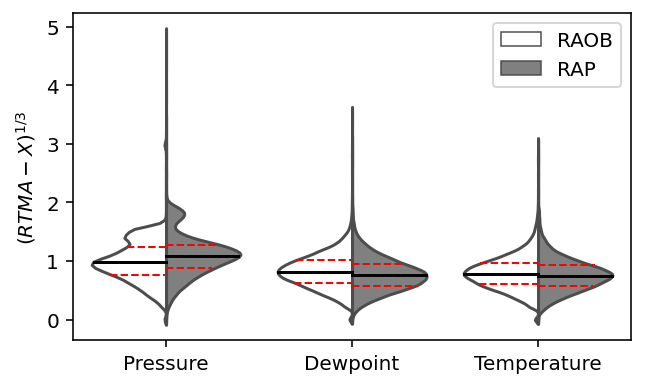

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 3))

palette = ['white', 'gray']

sns.violinplot(x='type', y='data', hue='model', data=df, scale="count",
               palette=palette, split=True, inner='quartile', ax=ax)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels)

for l in ax.lines:
    l.set_linestyle('--')
    l.set_linewidth(1)
    l.set_color('red')
    
for l in ax.lines[1::3]:
    l.set_linestyle('-')
    l.set_linewidth(1.5)
    l.set_color('black')
    
ax.set_ylabel('$(RTMA - X)^{1/3}$'); ax.set_xlabel(None); # $\sqrt[3]{|RTMA - X|}$

# plt.savefig('/home/stock/research/media/rtma_vs_rap_raob_2.pdf', dpi=300, bbox_inches='tight')

# RAP + RTMA

### Temperature

In [14]:
RAPtrain, RAOBtrain, _, RTMAtrain, RAPtest, RAOBtest, _, RTMAtest = parition(rap=rap, raob=raob, rtma=rtma, 
                                                                             shuffle=True)

input_dims = [dl.PRESSURE, dl.TEMPERATURE, dl.DEWPOINT, dl.ALTITUDE]

RAPtrain = RAPtrain[:, :, input_dims]
RAOBtrain = RAOBtrain[:, :, [dl.TEMPERATURE, dl.DEWPOINT]].reshape(RAOBtrain.shape[0], -1)

RAPtest = RAPtest[:, :, input_dims]
RAOBtest = RAOBtest[:, :, [dl.TEMPERATURE, dl.DEWPOINT]].reshape(RAOBtest.shape[0], -1)

RAPtrain.shape, RAOBtrain.shape, RTMAtrain.shape, RAPtest.shape, RAOBtest.shape, RTMAtest.shape

((64882, 256, 4),
 (64882, 512),
 (64882, 3, 3, 3),
 (16221, 256, 4),
 (16221, 512),
 (16221, 3, 3, 3))

## Basic Model

In [56]:
RAPtrain.shape[1:]

(256, 4)

In [59]:
    RTMAtrain.shape[1:]

(3, 3, 3)

In [29]:
hiddens_list = []
n_units_in_conv = [32, 32, 32, 32, 32]

# n_im_inputs, n_rap_inputs, hiddens_list,
# n_units_in_conv_layers, kernels_size_and_stride,
# n_outputs, dense_activation='tanh', rap_activation='relu'

nnet = nn.MultiConvolutionalNeuralNetwork(RAPtrain.shape[1:], RTMAtrain.shape[1:], 
                                          hiddens_list, n_units_in_conv, [(5, 1)]*len(n_units_in_conv), 
                                          RAOBtrain.shape[1], dense_activation='tanh', rap_activation='tanh',
                                          seed=None)

# nnet.model.summary()

nnet.train(RAPtrain, RTMAtrain, RAOBtrain, 20, 64, method='adam',
           validation=(RAPtest, RTMAtest, RAOBtest), verbose=True, learning_rate=0.0001)

epoch: 0, rmse 0.55230, val_rmse 0.44229
epoch: 4, rmse 0.40502, val_rmse 0.39725
epoch: 8, rmse 0.39584, val_rmse 0.38984
epoch: 12, rmse 0.39162, val_rmse 0.38713
epoch: 16, rmse 0.38891, val_rmse 0.38308
epoch: 19, rmse 0.38753, val_rmse 0.38306
finished!


MultiNeuralNetwork(512)
  Final objective value is 0.15018 in 74.4778 seconds.

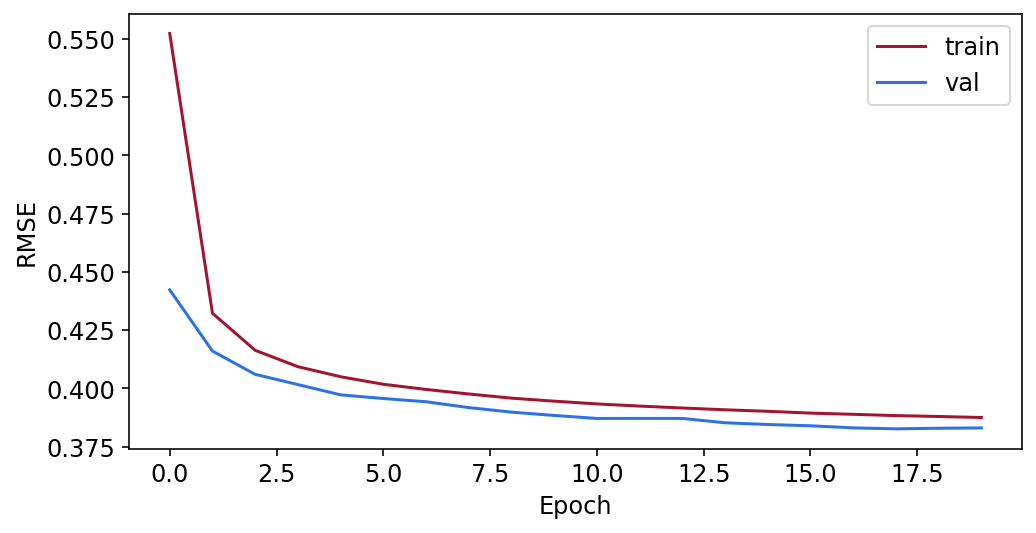

In [30]:
results.plot_loss(nnet)

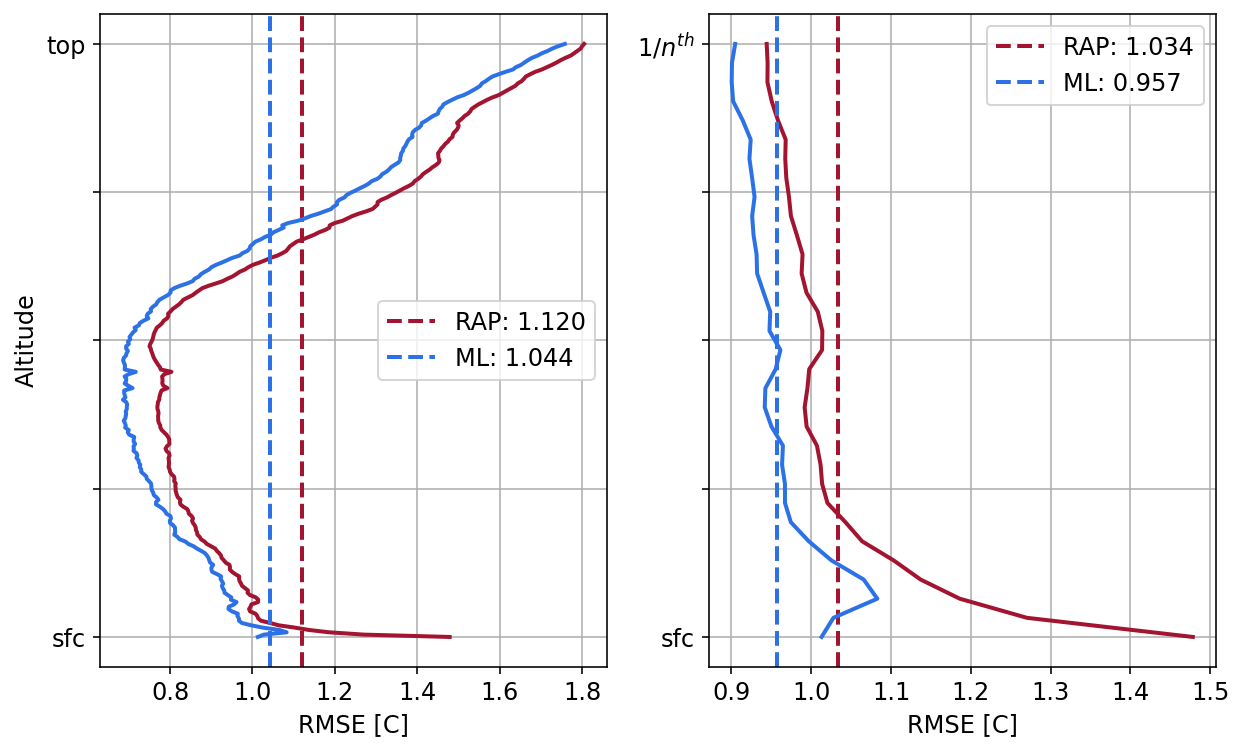

In [32]:
results.plot_altitude_rmse_verticle(nnet, {'im': RTMAtest, 'rap': RAPtest},
                                    RAOBtest, RAPtest[:,:,dl.TEMPERATURE])
                   #file_name=f"/home/stock/research/media/rap_goes_rmse.png")  

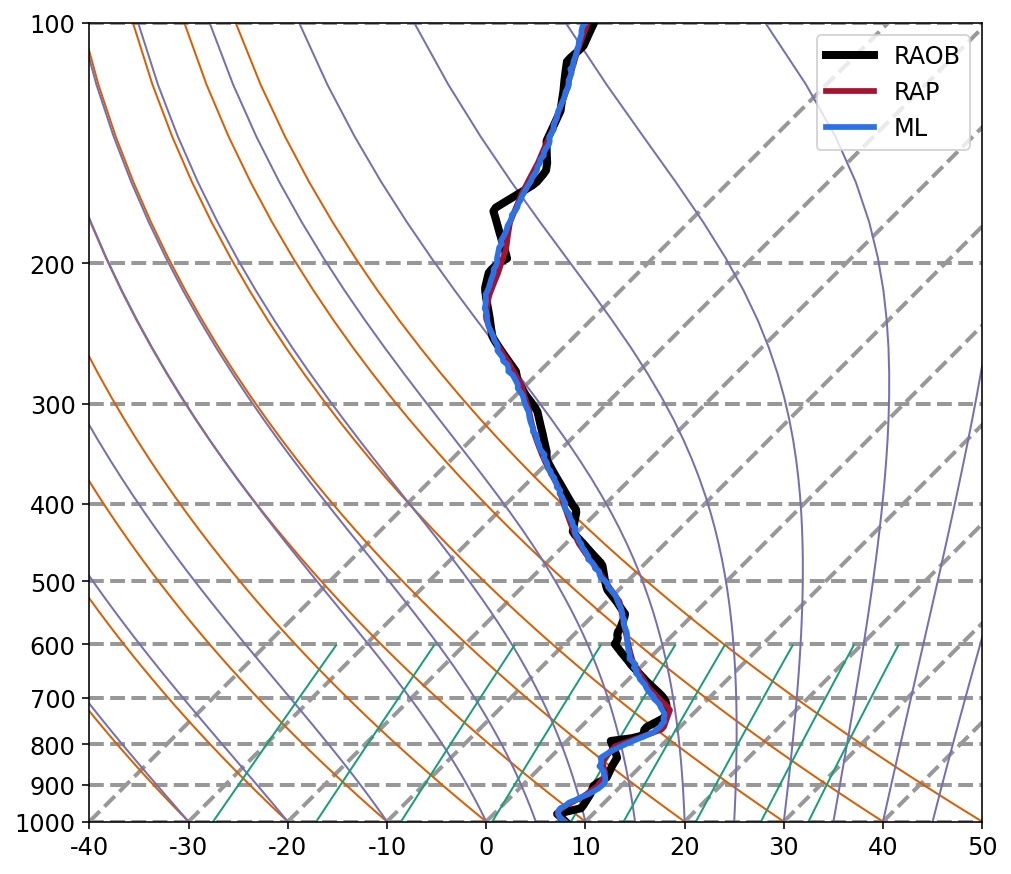

In [54]:
i = 115
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = RAPtest[i,:,dl.PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = RAOBtest[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = RAPtest[i,:,dl.TEMPERATURE]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = nnet.use({'im':RTMAtest[i:i+1],'rap':RAPtest[i:i+1]})[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

## Model Search

In [56]:
# https://github.com/tensorflow/tensorflow/issues/36465#issuecomment-631358715

im_hiddens_list = [[]] + [[nu] * nl for nu in [8, 16, 32] for nl in range(1, 3)]
n_units_in_conv_layers = [[nu] * nl for nu in [32, 128] for nl in range(2, 4)]

train_percentage = []
test_percentage = []

top = float('inf')
best_nnet = None

product = list(itertools.product(im_hiddens_list, n_units_in_conv_layers))

print(f'{len(product)} experiments.')
f = FloatProgress(min=0, max=len(product))
display(f)

for im_hiddens, n_units_in_conv in product:
    nnet = nn.MultiNeuralNetwork(RTMAtrain.shape[1:], RAPtrain.shape[1:],
                                 im_hiddens, n_units_in_conv, [(10, 1)]*len(n_units_in_conv), 
                                 RAOBtrain.shape[1], im_activation='tanh', rap_activation='tanh', 
                                 seed=1234)
    nnet.train(RTMAtrain, RAPtrain, RAOBtrain, 100, 64, method='adam',
               validation=(RTMAtest, RAPtest, RAOBtest), verbose=False, learning_rate=0.0001)

    Y = nnet.use({'im': RTMAtrain, 'rap': RAPtrain})
    train_percentage.append(ml.rmse(RAOBtrain, Y))

    Y = nnet.use({'im': RTMAtest, 'rap': RAPtest})
    temp = ml.rmse(RAOBtest, Y)
    test_percentage.append(temp)

    if temp < top:
        best_nnet = nnet
        top = temp
        
    del nnet
    
    f.value += 1

28 experiments.


FloatProgress(value=0.0, max=28.0)

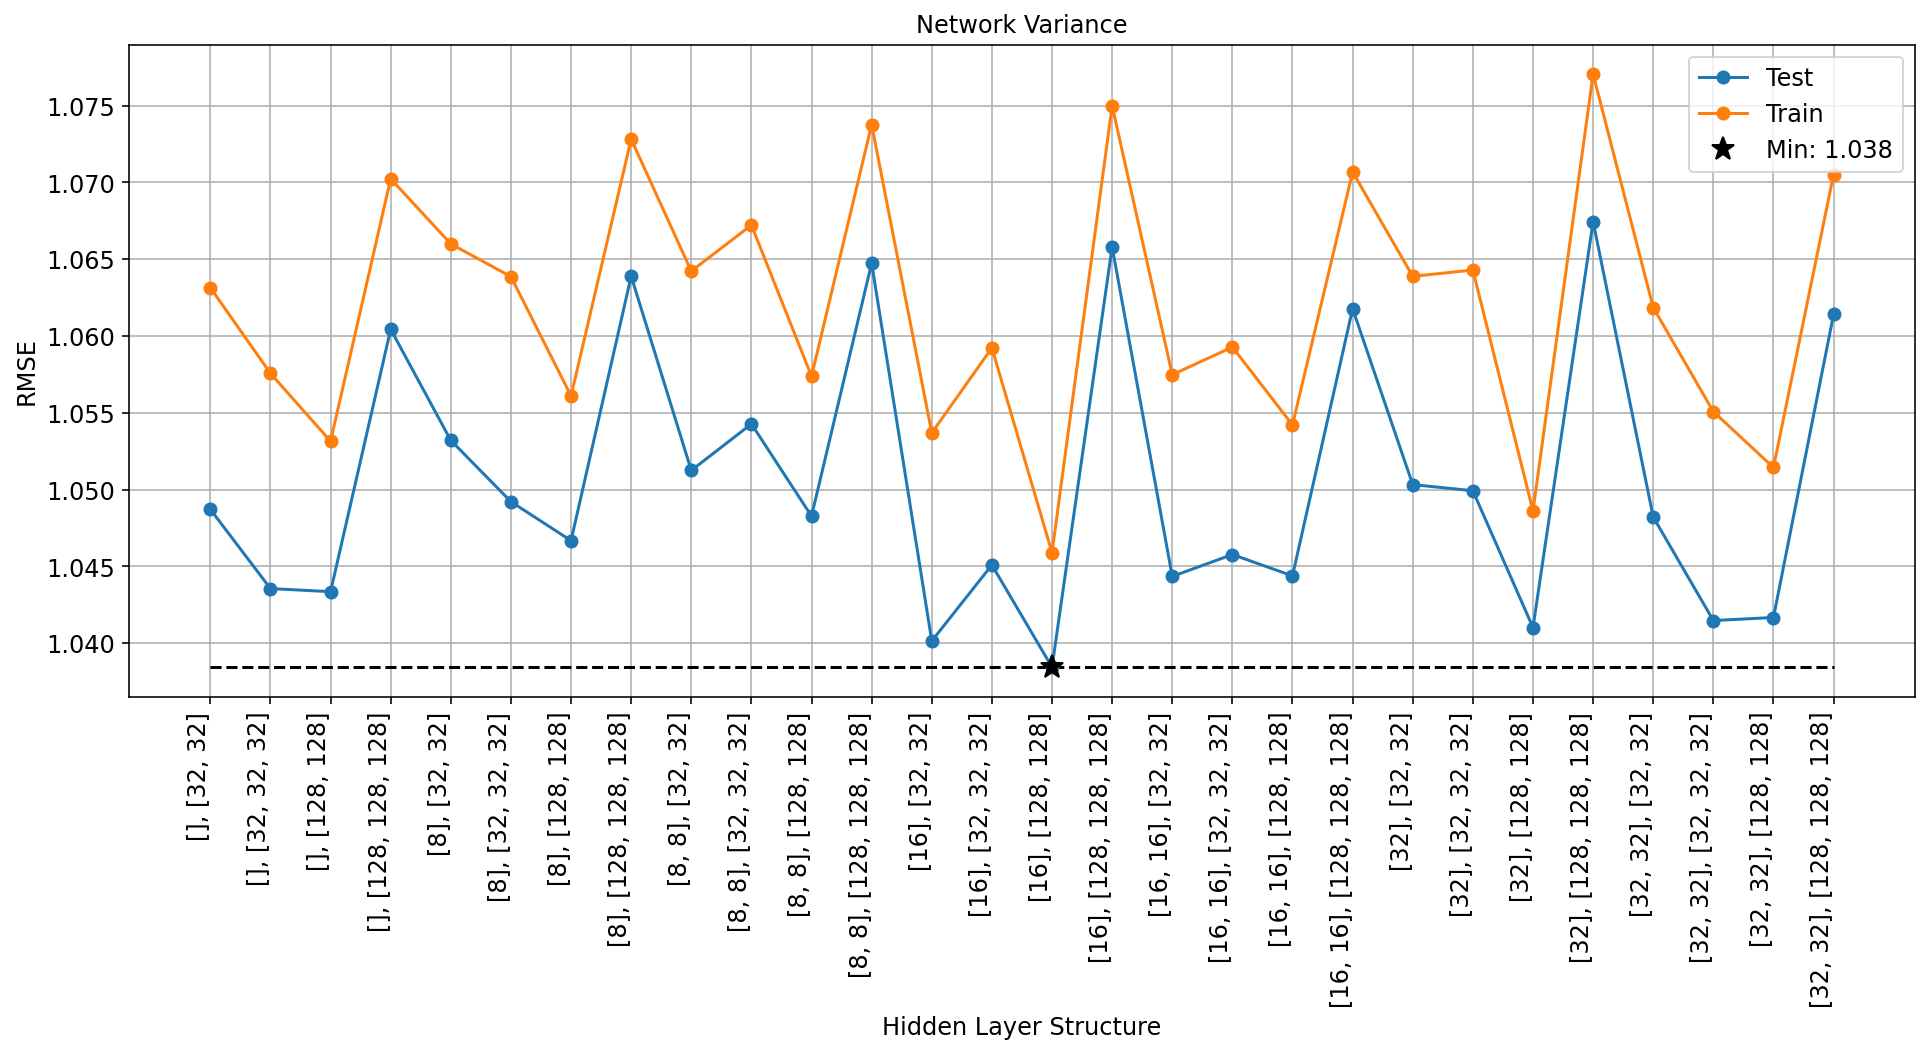

In [57]:
plt.figure(figsize=(16, 6))
plt.plot(test_percentage, 'o-')
plt.plot(train_percentage, 'o-')

top_index = np.argmin(test_percentage)
top = test_percentage[top_index]

plt.hlines(top, 0, len(product) - 1, linestyle='dashed', color='black')
plt.plot(top_index, top, 'k*', markersize=12)
plt.xticks(range(len(product)), [str(p)[1:-1] for p in product],
           rotation=90, horizontalalignment='right')

plt.legend(('Test', 'Train', 'Min: {:.3f}'.format(top)))
plt.grid(True); plt.title('Network Variance')
plt.xlabel('Hidden Layer Structure'); plt.ylabel('RMSE');

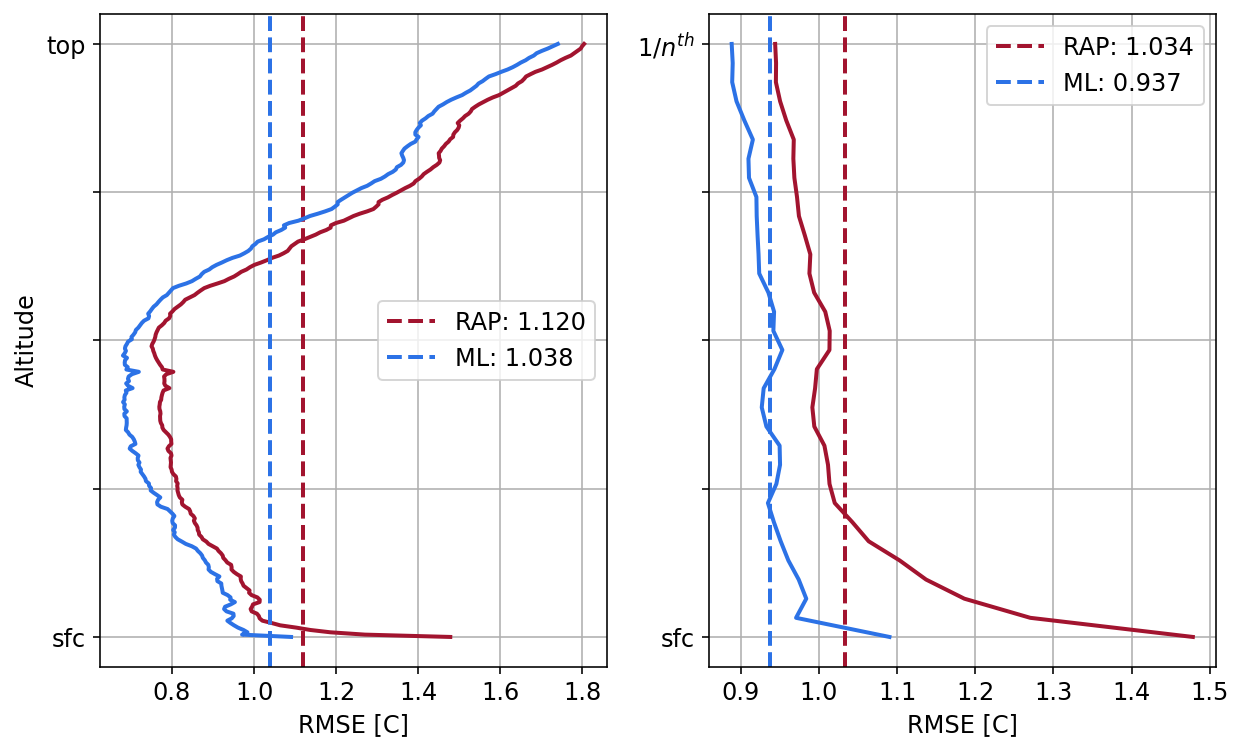

In [58]:
results.plot_altitude_rmse_verticle(best_nnet, {'im': RTMAtest, 'rap': RAPtest}, RAOBtest, RAPtest[:,:,-1], alt=raob[0, :, -1])
                   #file_name=f"/home/stock/research/media/rap_goes_rmse.png")  

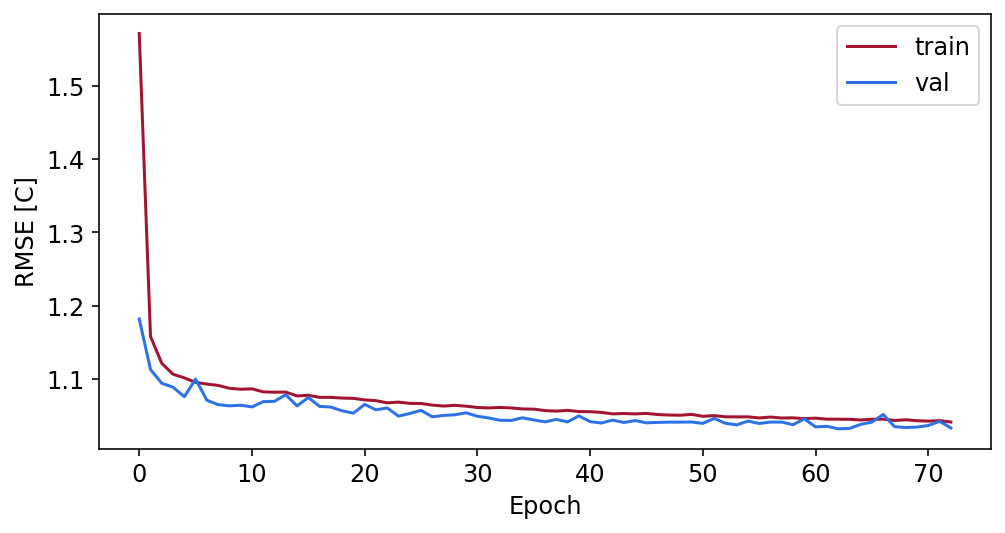

In [59]:
results.plot_loss(best_nnet)

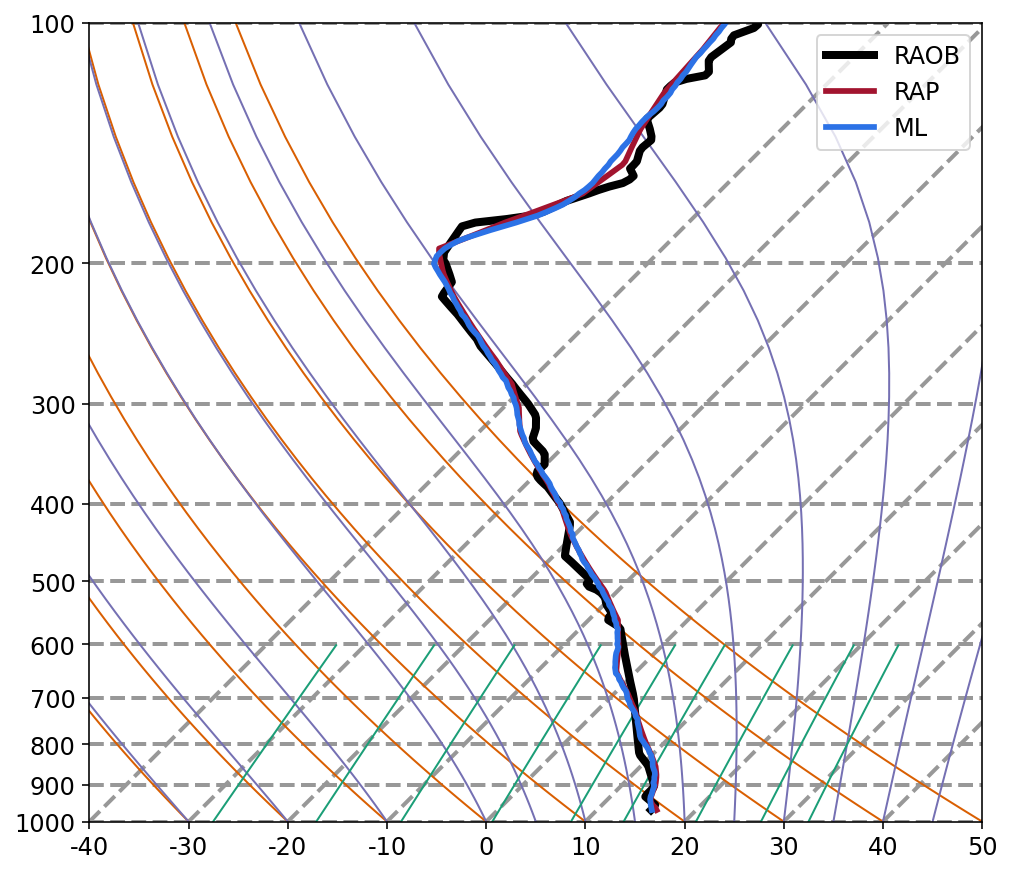

In [60]:
i = 17
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = RAPtrain[i,:,dl.PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = RAOBtrain[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = RAPtrain[i,:,-1]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = best_nnet.use({'im':RTMAtrain[i:i+1],'rap':RAPtrain[i:i+1]})[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

In [62]:
best_nnet.model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
rap (InputLayer)                [(None, 256, 2)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 256, 128)     2688        rap[0][0]                        
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 128, 128)     0           conv1d[0][0]                     
__________________________________________________________________________________________________
im (InputLayer)                 [(None, 3, 3, 3)]    0                                            
_______________________________________________________________________________________

In [9]:
rtma_type_indicies = np.arange(len(rtma_type))
combinations = []
for length in rtma_type_indicies:
    combinations += list(itertools.combinations(rtma_type_indicies, length+1))

In [13]:
all_trials = []
trials = 10

f = FloatProgress(min=0, max=len(combinations) * trials)
display(f)

for c in combinations:

    IMtrain = RTMAtrain[:,:,:, c]
    IMtest = RTMAtest[:,:,:, c]

    trial = []

    for t in range(trials):
        nnet = nn.MultiNeuralNetwork(IMtrain.shape[1:], RAPtrain.shape[1:],
                                    [16], [128, 128], [(10, 1)]*2, 
                                    RAOBtrain.shape[1], im_activation='tanh',
                                    rap_activation='tanh')

        nnet.train(IMtrain, RAPtrain, RAOBtrain, 100, 64, method='adam',
                   validation=(IMtest, RAPtest, RAOBtest), verbose=False, learning_rate=0.0001)

        Y = nnet.use({'im': IMtest, 'rap': RAPtest})
        rmse = ml.rmse(Y, RAOBtest)

        trial.append(rmse)
        f.value += 1
        
    all_trials.append(trial)
    
all_trials = np.asarray(all_trials)

FloatProgress(value=0.0, max=70.0)

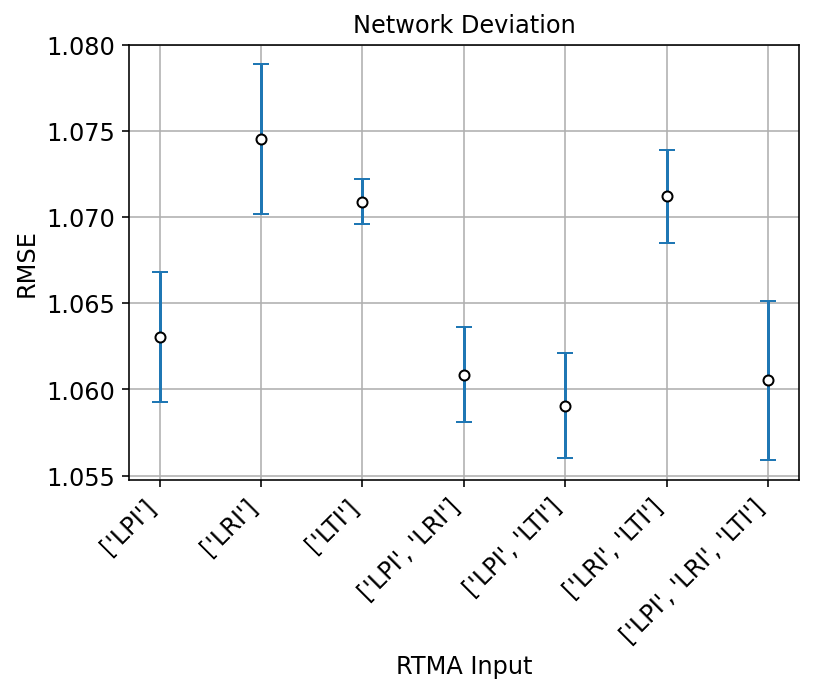

In [14]:
labels = [rtma_type[list(c)].tolist() for c in combinations]


fig, ax = plt.subplots(1, figsize=(6, 4))

ax.errorbar(np.arange(len(combinations)), all_trials.mean(axis=1), yerr=all_trials.std(axis=1),
             linestyle='None', marker='o', capsize=4, markersize=5,
             markeredgecolor='k', markerfacecolor='w')

ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45, horizontalalignment='right')

ax.grid(True); ax.set_title('Network Deviation')
ax.set_xlabel('RTMA Input'); ax.set_ylabel('RMSE');

In [10]:
rtma_type

array(['LPI', 'LRI', 'LTI'], dtype='<U3')

In [11]:
IMtrain = RTMAtrain[:,:,:, [0, 2]]
IMtest = RTMAtest[:,:,:, [0, 2]]

nnet = nn.MultiNeuralNetwork(IMtrain.shape[1:], RAPtrain.shape[1:],
                             [16], [128, 128], [(10, 1)]*2, 
                             RAOBtrain.shape[1], im_activation='tanh',
                             rap_activation='tanh')

nnet.train(IMtrain, RAPtrain, RAOBtrain, 100, 64, method='adam',
           validation=(IMtest, RAPtest, RAOBtest), verbose=True, learning_rate=0.0001)

epoch: 0, rmse 1.33415, val_rmse 1.12456
epoch: 20, rmse 1.05155, val_rmse 1.04447
epoch: 40, rmse 1.04211, val_rmse 1.04760
epoch: 60, rmse 1.03595, val_rmse 1.03638


MultiNeuralNetwork(256)
  Final objective value is 0.02840 in 201.9333 seconds.

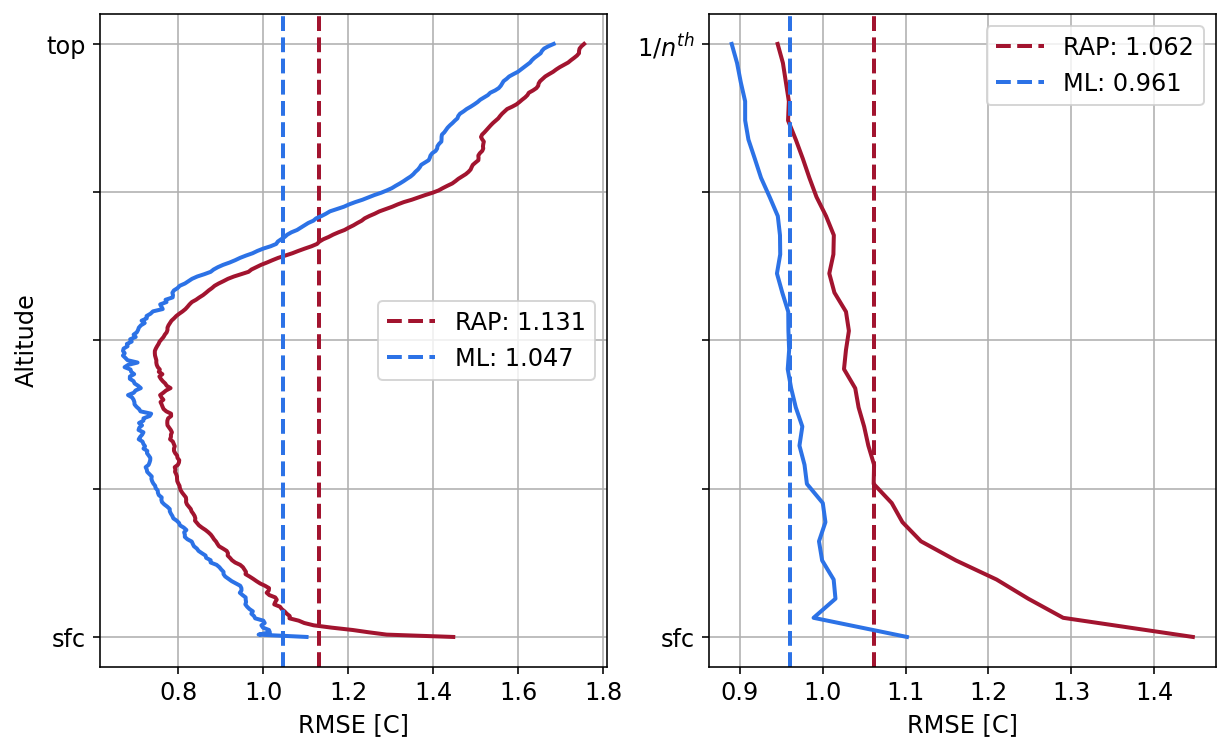

In [12]:
results.plot_altitude_rmse_verticle(nnet, {'im': IMtest, 'rap': RAPtest}, RAOBtest,
                                    RAPtest[:,:,dl.TEMPERATURE], alt=raob[0, :, -1])  

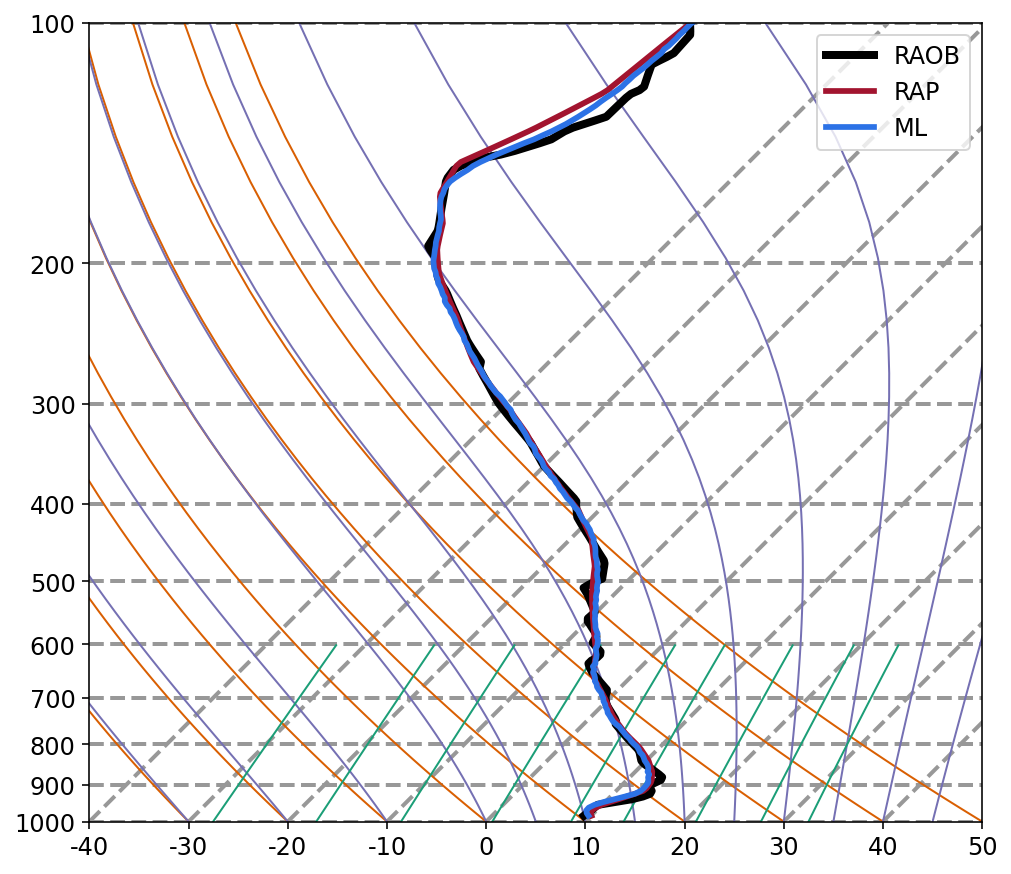

In [19]:
i = 0
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = RAPtest[i,:,dl.PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = RAOBtest[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = RAPtest[i,:,dl.TEMPERATURE]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = nnet.use({'im':IMtest[i:i+1],'rap':RAPtest[i:i+1]})[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

### Moisture

In [207]:
RAPtrain, RAOBtrain, _, RTMAtrain, RAPtest, RAOBtest, _, RTMAtest = parition(rap=rap, raob=raob, rtma=rtma)

input_dims = [PRESSURE, DEWPOINT]

RAPtrain = RAPtrain[:, :, input_dims]
RAOBtrain = RAOBtrain[:, :, DEWPOINT]

RAPtest = RAPtest[:, :, input_dims]
RAOBtest = RAOBtest[:, :, DEWPOINT]

RAPtrain.shape, RAOBtrain.shape, RTMAtrain.shape, RAPtest.shape, RAOBtest.shape, RTMAtest.shape

((587, 256, 2),
 (587, 256),
 (587, 3, 3, 3),
 (147, 256, 2),
 (147, 256),
 (147, 3, 3, 3))

In [208]:
# https://github.com/tensorflow/tensorflow/issues/36465#issuecomment-631358715

goes_hiddens_list = [[nu] * nl for nu in [8, 16, 32] for nl in range(1, 4)]
n_units_in_conv_layers = [[nu] * nl for nu in [16, 32, 128] for nl in range(1, 4)]

train_percentage = []
test_percentage = []

top = float('inf')
best_nnet = None

product = list(itertools.product(goes_hiddens_list, n_units_in_conv_layers))

f = FloatProgress(min=0, max=len(product))
display(f)

for goes_hiddens, n_units_in_conv in product:
    nnet = nn.MultiNeuralNetwork(RTMAtrain.shape[1:], RAPtrain.shape[1:],
                                    goes_hiddens, n_units_in_conv, [(10, 1)]*len(n_units_in_conv), 
                                    RAOBtrain.shape[1], im_activation='tanh', rap_activation='tanh', seed=1234)
    nnet.train(RTMAtrain, RAPtrain, RAOBtrain, 50, 32, method='adam',
               verbose=False, learning_rate=0.001)

    Y = nnet.use({'im': RTMAtrain, 'rap': RAPtrain})
    train_percentage.append(ml.rmse(RAOBtrain, Y))

    Y = nnet.use({'im': RTMAtest, 'rap': RAPtest})
    temp = ml.rmse(RAOBtest, Y)
    test_percentage.append(temp)

    if temp < top:
        best_nnet = nnet
        top = temp
        
    del nnet
    
    f.value += 1

FloatProgress(value=0.0, max=81.0)

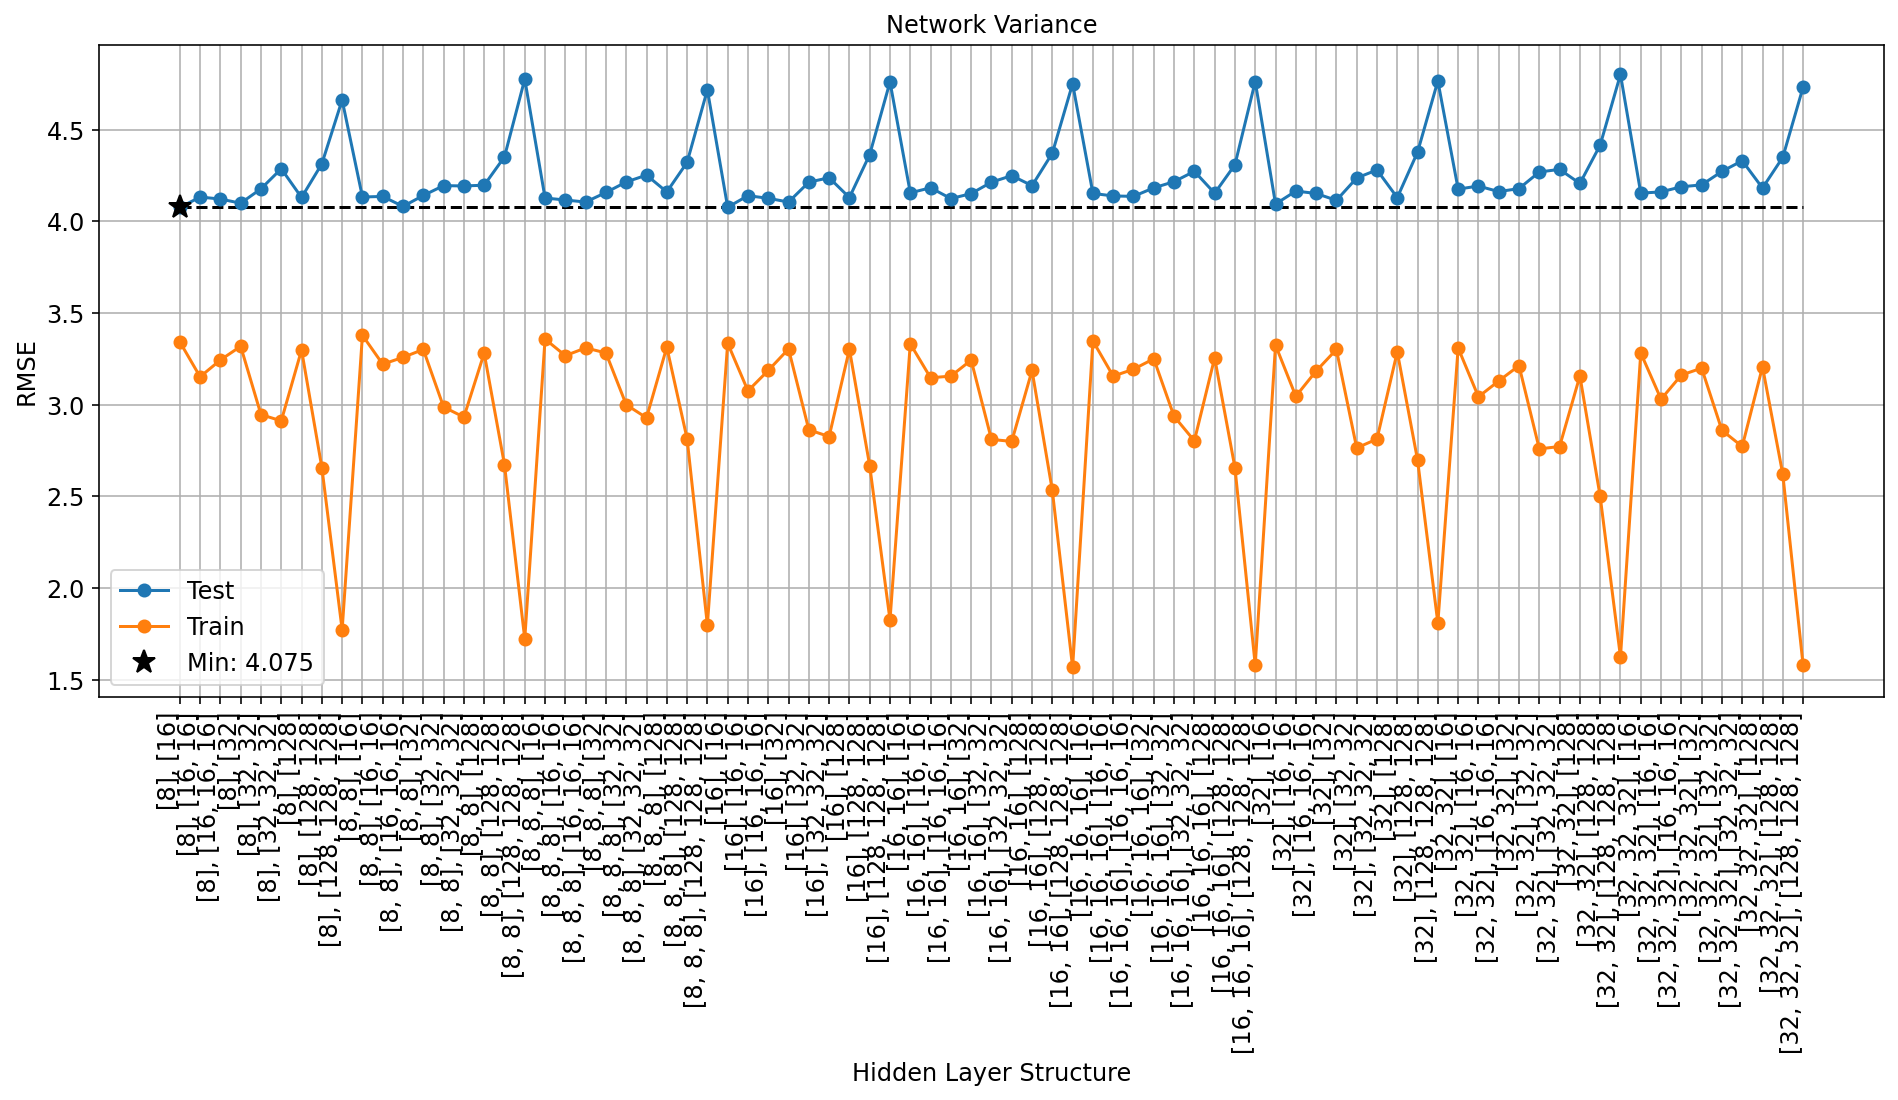

In [209]:
plt.figure(figsize=(16, 6))
plt.plot(test_percentage, 'o-')
plt.plot(train_percentage, 'o-')

top_index = np.argmin(test_percentage)
top = test_percentage[top_index]

plt.hlines(top, 0, len(product) - 1, linestyle='dashed', color='black')
plt.plot(top_index, top, 'k*', markersize=12)
plt.xticks(range(len(product)), [str(p)[1:-1] for p in product],
           rotation=90, horizontalalignment='right')

plt.legend(('Test', 'Train', 'Min: {:.3f}'.format(top)))
plt.grid(True); plt.title('Network Variance')
plt.xlabel('Hidden Layer Structure'); plt.ylabel('RMSE');

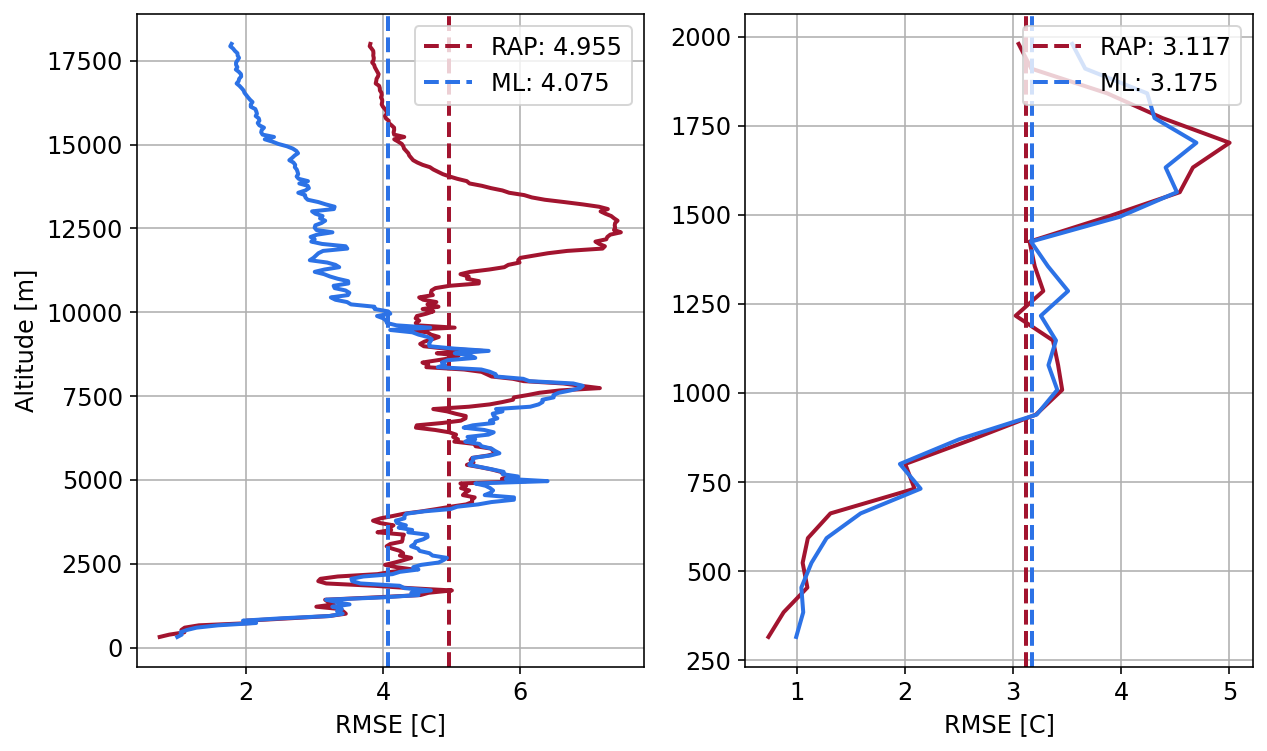

In [210]:
plot_altitude_rmse_verticle(best_nnet, {'im': RTMAtest, 'rap': RAPtest}, RAOBtest, RAPtest[:,:,-1], alt=raob[0, :, -1])
                   #file_name=f"/home/stock/research/media/rap_goes_rmse.png")  

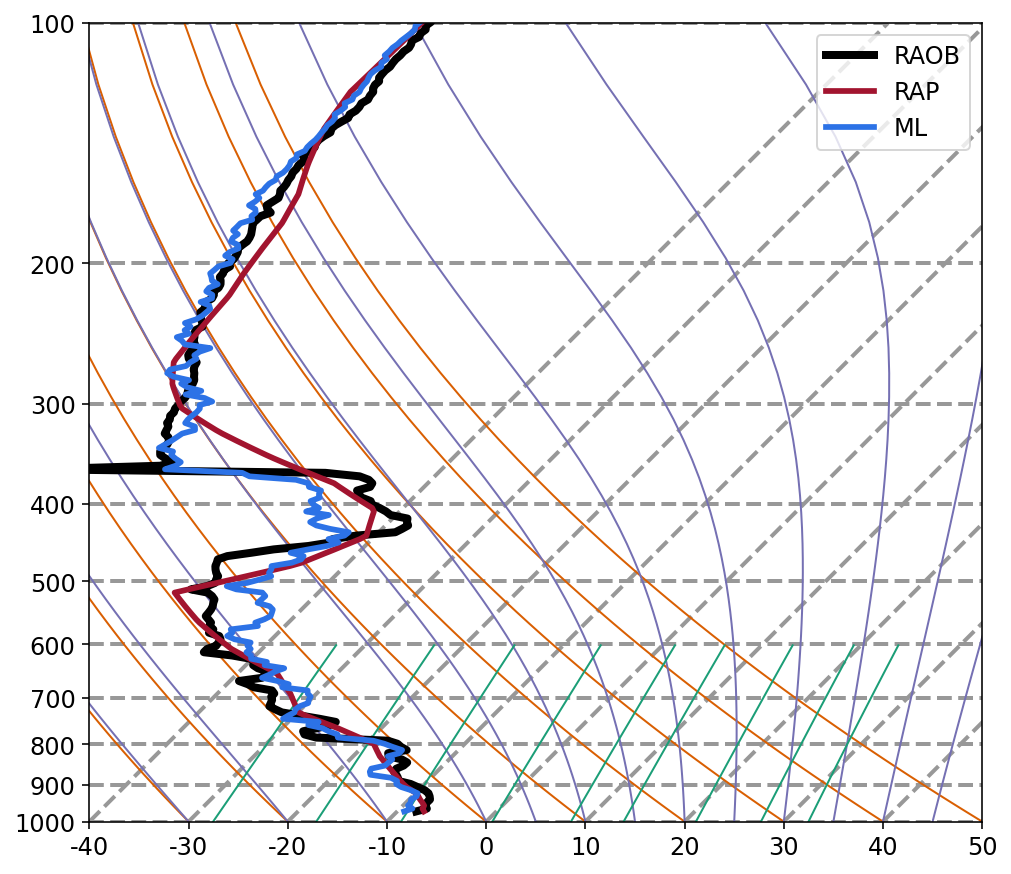

In [213]:
i = 17
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = RAPtrain[i,:,PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = RAOBtrain[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = RAPtrain[i,:,-1]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = best_nnet.use({'im':RTMAtrain[i:i+1],'rap':RAPtrain[i:i+1]})[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

In [216]:
rtma_type_indicies = np.arange(len(rtma_type))
combinations = []
for length in rtma_type_indicies:
    combinations += list(itertools.combinations(rtma_type_indicies, length+1))

In [219]:
all_trials = []

for c in combinations:

    IMtrain = RTMAtrain[:,:,:, c]
    IMtest = RTMAtest[:,:,:, c]

    trial = []

    for t in range(10):
        nnet = nn.MultiNeuralNetwork(IMtrain.shape[1:], RAPtrain.shape[1:],
                                    [8], [16], [(10, 1)], 
                                    RAOBtrain.shape[1], im_activation='tanh',
                                    rap_activation='tanh')

        nnet.train(IMtrain, RAPtrain, RAOBtrain, 50, 32, method='adam',
                   verbose=False, learning_rate=0.001)

        Y = nnet.use({'im': IMtest, 'rap': RAPtest})
        rmse = ml.rmse(Y, RAOBtest)

        trial.append(rmse)
        
    all_trials.append(trial)
    
all_trials = np.asarray(all_trials)

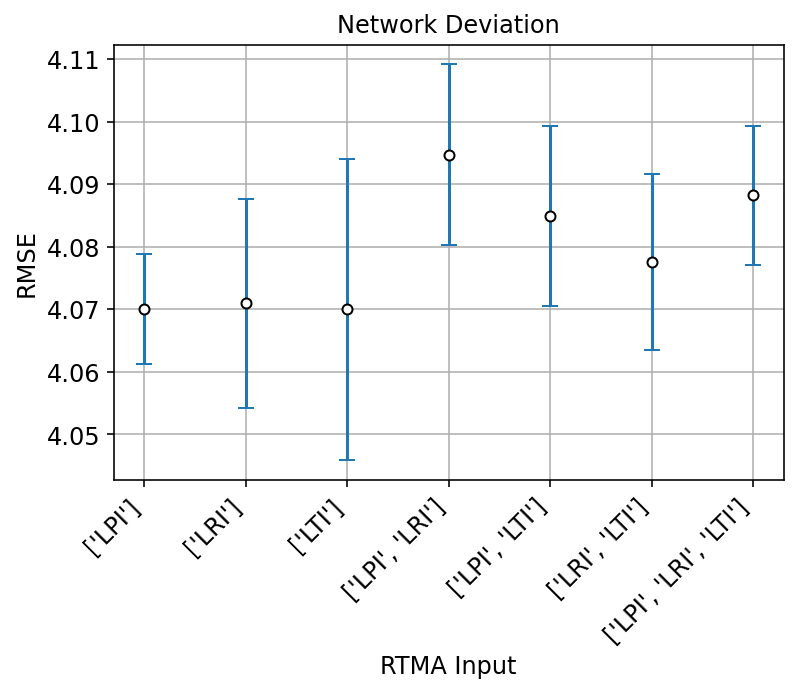

In [220]:
labels = [rtma_type[list(c)].tolist() for c in combinations]

fig, ax = plt.subplots(1, figsize=(6, 4))

ax.errorbar(np.arange(len(combinations)), all_trials.mean(axis=1), yerr=all_trials.std(axis=1),
             linestyle='None', marker='o', capsize=4, markersize=5,
             markeredgecolor='k', markerfacecolor='w')

ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45, horizontalalignment='right')

ax.grid(True); ax.set_title('Network Deviation')
ax.set_xlabel('RTMA Input'); ax.set_ylabel('RMSE');

In [221]:
rtma_type

array(['LPI', 'LRI', 'LTI'], dtype='<U3')

In [222]:
IMtrain = RTMAtrain[:,:,:, (0,)]
IMtest = RTMAtest[:,:,:, (0,)]

nnet = nn.MultiNeuralNetwork(IMtrain.shape[1:], RAPtrain.shape[1:],
                             [16], [16], [(10, 1)], 
                             RAOBtrain.shape[1], im_activation='tanh',
                             rap_activation='tanh')

nnet.train(IMtrain, RAPtrain, RAOBtrain, 50, 32, method='adam',
           verbose=False, learning_rate=0.001)

MultiNeuralNetwork(256)
  Final objective value is 0.27589 in 2.4585 seconds.

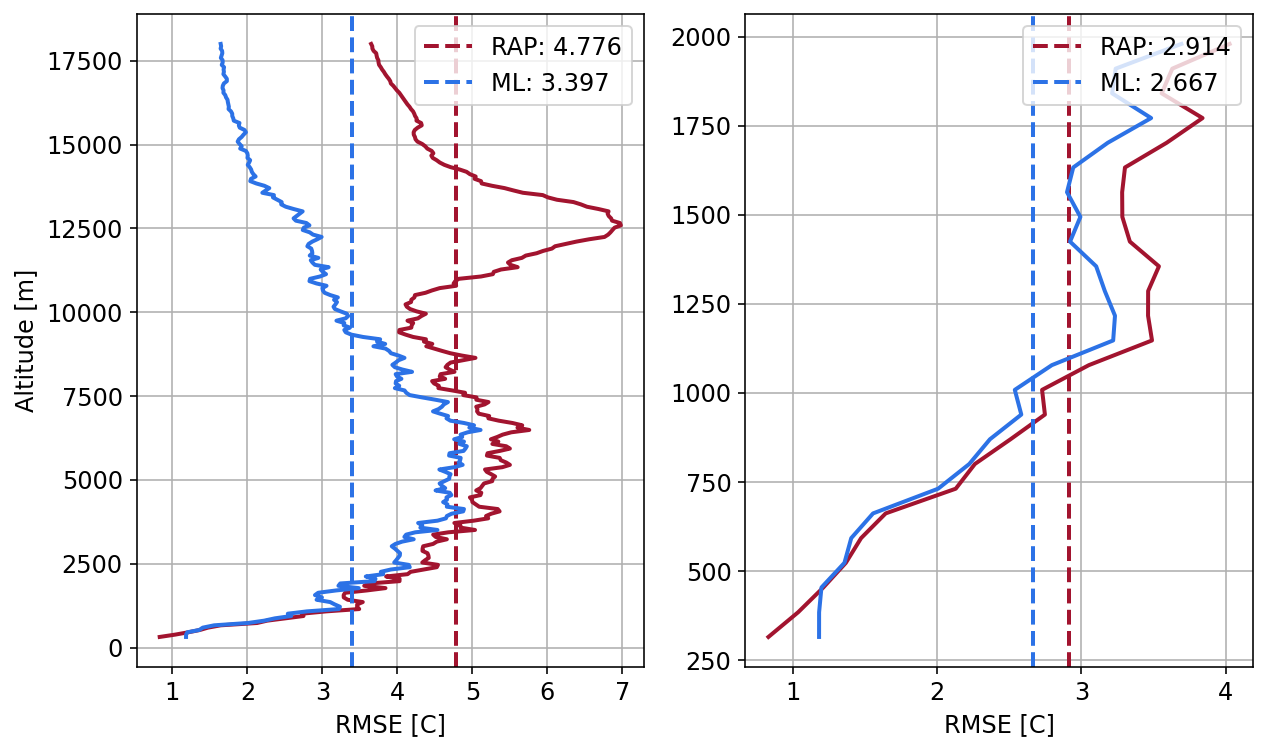

In [223]:
plot_altitude_rmse_verticle(nnet, {'im': IMtrain, 'rap': RAPtrain}, RAOBtrain, RAPtrain[:,:,TEMPERATURE], alt=raob[0, :, -1])  